In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as scs
from scipy.interpolate import CubicSpline
import scipy.spatial.transform as sst

In [449]:
def read_input():
    lines = open('results').readlines()
    results = []
    coordinates = []
    for line in lines:
        parts = line.strip().split()
        row = {}
        if parts[0] == '#R':
            q = parts[1].strip('/').split('/')
            row['target'] = q[-2]
            if row['target'] == 'NN-2':
                row['target'] = 'N2-2'
            row['box'] = int(q[-1].split('-')[-1])
            row['energies'] = np.array([float(_) for _ in parts[2:]])
            row['numatoms'] = len(row['energies'])
            results.append(row)
        if parts[0] == '#C':
            numatoms = int(parts[1])
            row['numatoms'] = numatoms
            row['zs'] = [int(float(_)) for _ in parts[2:2+numatoms]]
            row['coords'] = np.array([float(_) for _ in parts[-3*numatoms:]]).reshape(-1, 3)
            coordinates.append(row)
    return pd.DataFrame(results), pd.DataFrame(coordinates)
r, c = read_input()
def read_energies2():
    lines = open('results-energies').readlines()
    energies = []
    for line in lines:
        parts = line.strip().split()
        row = {}
        row['energy'] = float(parts[-2])
        parts = parts[0].split('/')
        row['target'] = parts[0]
        if row['target'] == 'NN-2':
            row['target'] = 'N2-2'
        row['box'] = int(parts[1].split('-')[-1])
        energies.append(row)
    return pd.DataFrame(energies)
def read_energies():
    return pd.merge(read_energies2()['box target'.split()], pd.read_csv('631results-energies', sep=' ', header=None, names='target energy'.split()), on='target')
def get_nuc_nuc_energy():
    def _get_e(row):
        e = np.outer(row.zs, row.zs)/ scs.distance.squareform(scs.distance.pdist(row.coords))
        np.fill_diagonal(e, 0)
        return e.sum(axis=0)/2    
    q = pd.merge(c, r, left_index=True, right_index=True)['coords zs target'.split()].drop_duplicates('target')
    q['enn'] = q.apply(_get_e, axis=1)
    return q['target enn zs'.split()]
    
energy_data = pd.merge(read_energies(), get_nuc_nuc_energy())

# extrapolate for infinite box size (in df as 1000)
# alchemical energies: extrapolation for 1/box size at 0 via linreg
# total energies: already converged at box site 20
rows = []
for name, group in r.sort_values('box').groupby('target'):
    extrapolated = []
    for site in range(group.numatoms.values[0]):
        es = np.array(group.energies.values.tolist())
        #plt.plot(1/group.box, es[:, site], label=name)
        try:
            extrapolated.append(np.polyfit(1/group.box, es[:, site], 1)[1])
        except:
            extrapolated.append(es[-1, site])
    row = {}
    row['box'] = 1000
    row['energies'] = extrapolated
    row['numatoms'] = len(extrapolated)
    row['target'] = name
    rows.append(row)
r = pd.concat((r,pd.DataFrame(rows)))
q = energy_data.query('box == 20').copy()
q.box = 1000
energy_data = pd.concat((energy_data, q))

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


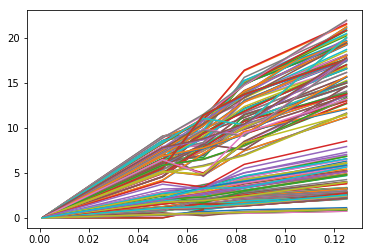

In [450]:
def visualise_box_impact():
    for target, group in r.sort_values('box').groupby('target'):
        ys = np.array(group.energies.values.tolist()).T
        if len(ys.shape) == 3:
            ys = ys[0]
        xs = group['box'].values
        for row in ys:
            plt.plot(1/xs, row - row[-1])
visualise_box_impact()

N 1.163726732564959
N 1.165118315251895
O 1.1723011994229955
C 1.1880879196198042
F 1.186571620012217
B 1.2656220339130573


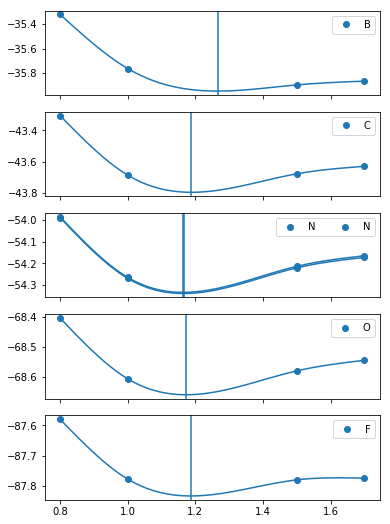

In [451]:
def dimer_plot(box):
    f, axs = plt.subplots(5, 1, figsize=(6, 9), sharex=True)
    pane = {'N2': (2,2), 'CO': (3, 1), 'BF': (4, 0)}
    lookup = {7:'N', 8:'O', 6:'C', 9:'F', 5:'B'}
    for tidx, target in enumerate('N2 CO BF'.split()):
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == box].sort_values('target')
        energies= np.array(q.energies.values.tolist())
        enn = np.array(q.enn.values.tolist())
        ds = np.array([float(_.split('-')[-1]) for _ in q.target.values])
        zs = q.zs.values[0]
        shift = (q.energy.values + energies.sum(axis=1) - enn.sum(axis=1))
        if target == 'N2':
            #1:1
            sfactor = 1.
        if target == 'CO':
            sfactor = 6./8.
        if target == 'BF':
            sfactor = 5/9.
        shift = (shift/(1+sfactor), sfactor*shift/(1+sfactor))
        if target != 'N2d':
            mask = np.where((ds < 2.0) & (ds != 1.2))[0]
        else:
            mask = np.where((ds < 2.0))[0]
        for site in (0,1):
            xs = ds[mask]
            ys = (-energies[:, site] + enn[:, site] + shift[site])[mask]
            xss = np.linspace(min(xs), max(xs), 50)
            spl = CubicSpline(xs, ys, bc_type='natural')
            ax = axs[pane[target][site]]
            try:
                root = [_ for _ in spl.derivative().roots() if 0.8 < _ and _ < 1.4][0]
                ax.axvline(root)
                print (lookup[zs[site]], root)
            except:
                pass
            yss = spl(xss)
            ax.plot(xs, ys, 'o', label='%s' % lookup[zs[site]], color='C0')
            ax.plot(xss, yss, color='C0')
            ax.legend(ncol=2)
        #plt.xlabel('Bond length [$\mathrm{\AA}$]')
    
    return 
dimer_plot(1000)

26.06233081644683


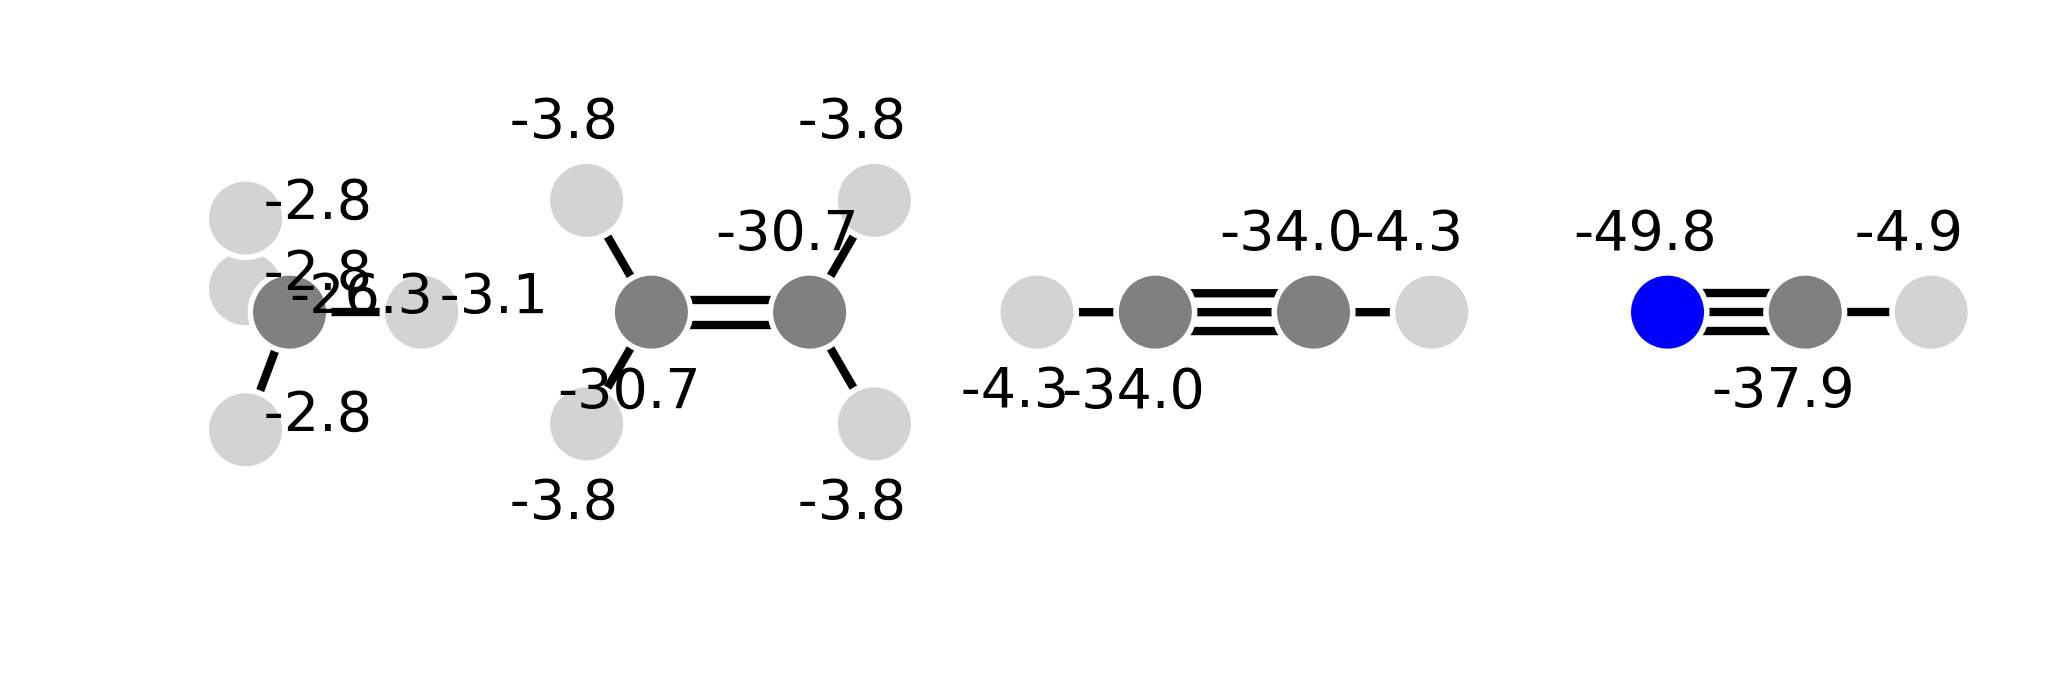

In [564]:
def draw_spn():
    def draw_mol(coords, zs, cog, bonds):
        coords += cog - coords.mean(axis=0)
    
        axs.scatter(coords[:, 0], coords[:, 1],edgecolors=[outlinecolors[_] for _ in zs], c=[colors[_] for _ in zs], s=200)
        def draw_bond(a, b, order):
            if order == 2:
                delta = coords[b, 0:2] - coords[a, 0:2]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.2
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
            if order == 3:
                delta = coords[b, 0:2] - coords[a, 0:2]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.3
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                plt.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
            if order == 1:
                plt.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
        #for aidx in range(c.natoms):
        #    axs.text(c.coordinates[aidx, 0], c.coordinates[aidx, 1], str(aidx))

        for afrom, ato, aorder in bonds:
            draw_bond(afrom, ato, aorder)       
        
        
    f, axs = plt.subplots(1, 1, dpi=400)
    axs.set_aspect('equal')
    colors = {6: 'grey', 1: 'lightgrey', 7: 'blue', 8: 'red'}
    outlinecolors = {6: 'white', 1: 'white', 7: 'white', 8: 'white'}
    
    plottotal=True
    
    #methane
    coords = c.iloc[16].coords
    zs = c.iloc[16].zs
    draw_mol(coords, zs, (0., 0., 0.), [(0, 4, 1), (1, 4, 1), (2, 4, 1), (3, 4, 1)])
    
    target = 'methane'
    q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
    q = q[q.box == 1000]
    hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
    shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
    ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    if plottotal:
        ann = ann_total
    else:
        ann = ann_elec
    for aidx in range(len(ann)):
        axs.text(coords[aidx, 0], coords[aidx, 1], '%5.1f' % ann[aidx])
        
    #ethylene
    coords = c.iloc[90].coords
    zs = c.iloc[90].zs
    rot, _ = sst.Rotation.match_vectors([[0,1,0], [1,0,0]], [coords[0] - coords[1], coords[0] - coords[2]])
    coords = rot.apply(coords)
    draw_mol(coords, zs, (7., 0., 0.), [(0, 4, 1), (1, 4, 1), (2, 5, 1), (3, 5, 1), (4, 5, 2)])
    
    target = 'ethylene'
    q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
    q = q[q.box == 1000]
    hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
    shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
    ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    if plottotal:
        ann = ann_total
    else:
        ann = ann_elec
    for aidx in range(len(ann)):
        axs.text(coords[aidx, 0]-1.5, coords[aidx, 1]+1-2.5*(aidx%2), '%5.1f' % ann[aidx])
    
    # acetylene
    coords = c.iloc[79].coords
    zs = c.iloc[79].zs
    h = coords[2] - coords[1]
    rot, _ = sst.Rotation.match_vectors([[1,1,0], [1,-1,0]], [coords[0] - coords[1], h])
    coords = rot.apply(coords)
    draw_mol(coords, zs, (15., 0., 0.), [(0, 2, 1), (1, 3, 1), (2, 3, 3)])
    
    target = 'acetylene'
    q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
    q = q[q.box == 1000]
    hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
    shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
    ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    if plottotal:
        ann = ann_total
    else:
        ann = ann_elec
    for aidx in range(len(ann)):
        axs.text(coords[aidx, 0]-1.5, coords[aidx, 1]+1-2.5*(aidx%2), '%5.1f' % ann[aidx])
    
    # HCN
    coords = c.iloc[76].coords
    zs = c.iloc[76].zs
    h = coords[1] - coords[2]
    rot, _ = sst.Rotation.match_vectors([[1,1,0], [1,-1,0]], [coords[0] - coords[1], h])
    coords = rot.apply(coords)
    draw_mol(coords, zs, (24, 0., 0.), [(0, 1, 1), (1, 2, 3)])
    
    target = 'HCN'
    q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
    q = q[q.box == 1000]
    
    hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
    shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
    ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
    if plottotal:
        ann = ann_total
    else:
        ann = ann_elec
    
    print (coords[0, 0])
    for aidx in range(len(ann)):
        axs.text(coords[aidx, 0]-1.5, coords[aidx, 1]+1-2.5*(aidx%2), '%5.1f' % ann[aidx])
    
    axs.set_ylim(-4, 4)
    axs.axis('off')
    
    plt.savefig('spn.pdf')
draw_spn()

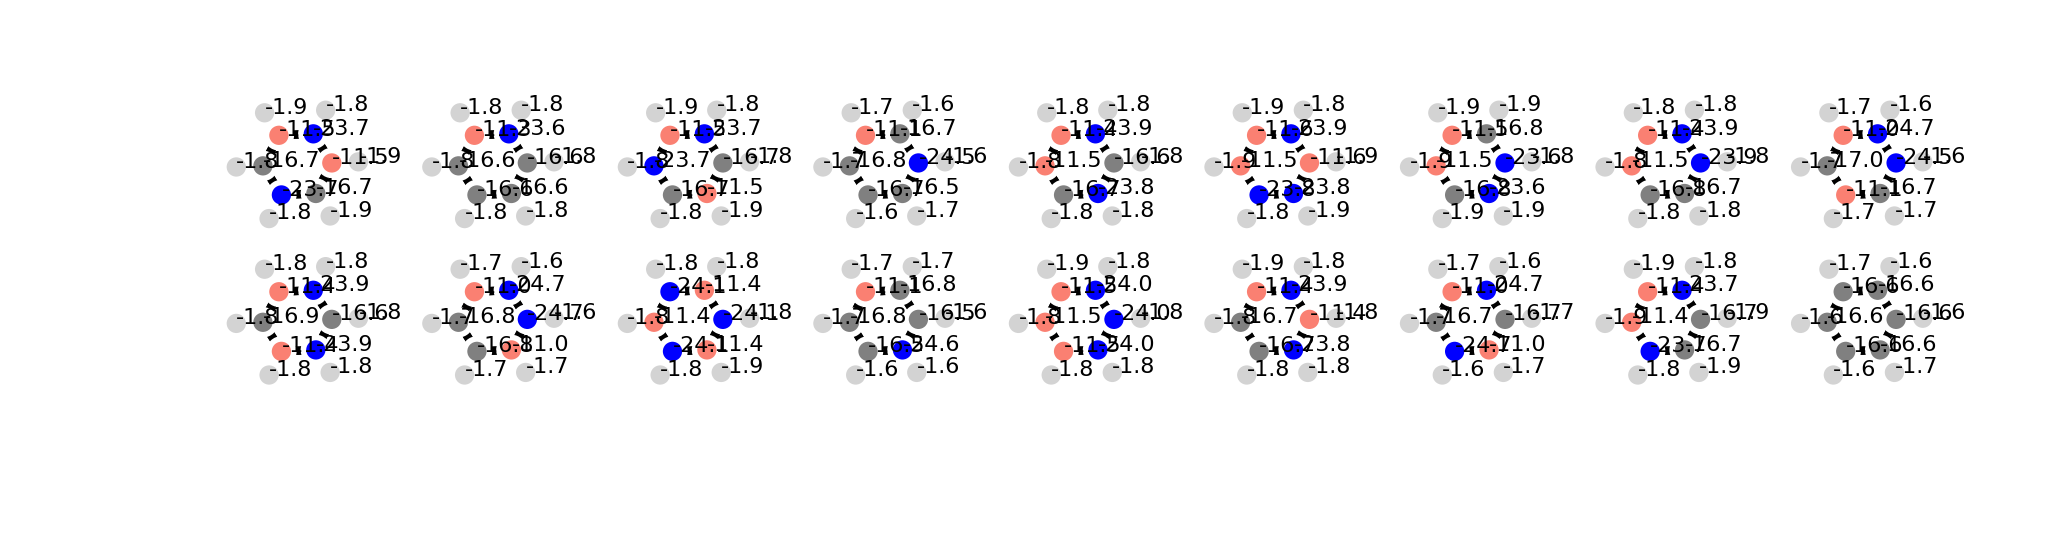

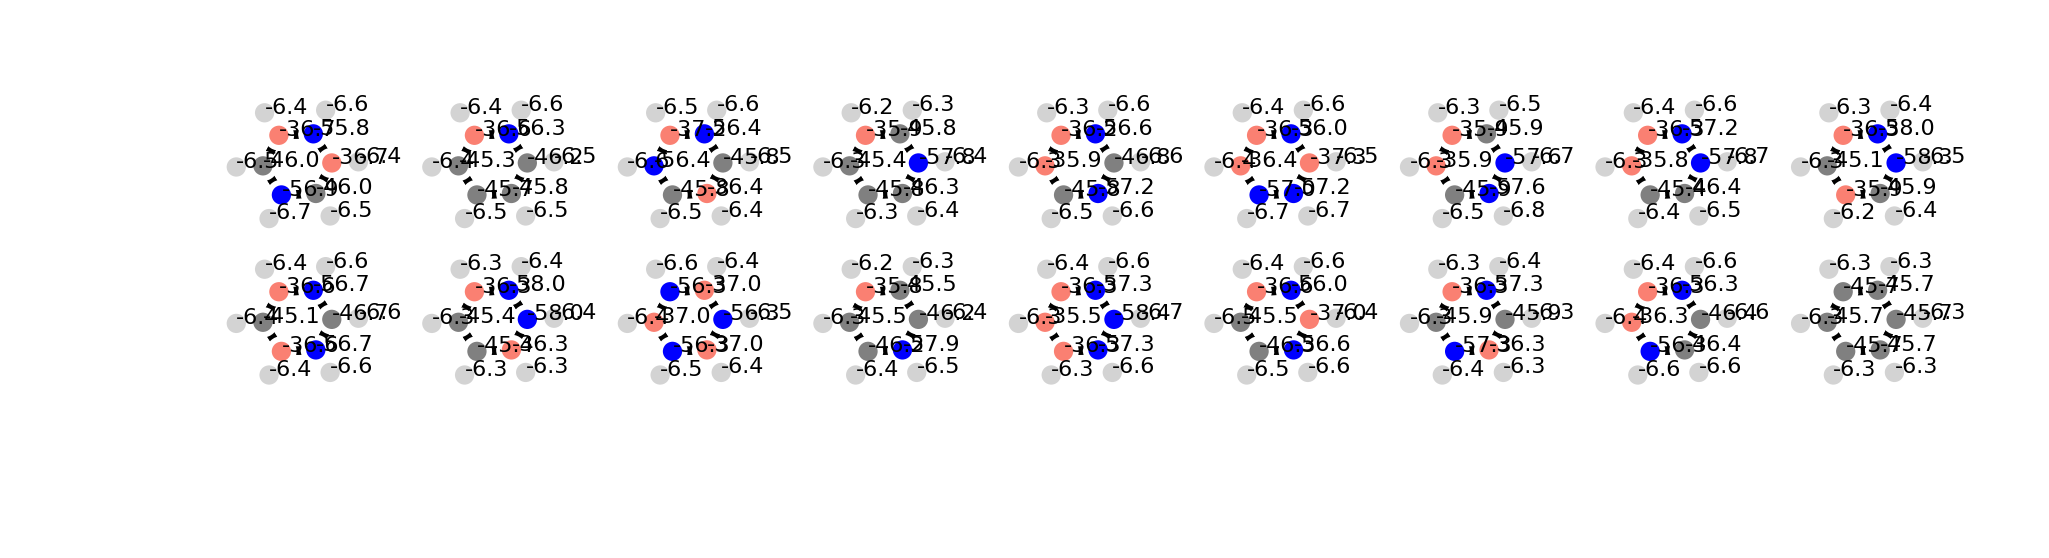

In [563]:
def draw_c6bn(plottotal):
    targets = r[r.numatoms==12].target.unique()
    def guess_bonds(qcoords):
        bonds = []
        for atom in range(6):
            ds = np.linalg.norm(qcoords[6:] - qcoords[atom], axis=1)
            bonds.append((atom, 6+np.argmin(ds), 1))
        for atom in range(6):
            ds = np.linalg.norm(qcoords[6:] - qcoords[6+atom], axis=1)
            order = np.argsort(ds)[1:3]
            for e in order:
                bonds.append((atom + 6, e+6, 1))
        return bonds
    def draw_mol(coords, zs, cog, bonds):
        coords += cog - coords.mean(axis=0)
    
        axs.scatter(coords[:, 0], coords[:, 1],edgecolors=[outlinecolors[_] for _ in zs], c=[colors[_] for _ in zs], s=20)
        def draw_bond(a, b, order):
            if order == 2:
                delta = coords[b, 0:2] - coords[a, 0:2]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.2
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
            if order == 3:
                delta = coords[b, 0:2] - coords[a, 0:2]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.3
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                plt.plot(xs, ys, color='black', zorder=-1)
                plt.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
            if order == 1:
                plt.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
        #for aidx in range(c.natoms):
        #    axs.text(c.coordinates[aidx, 0], c.coordinates[aidx, 1], str(aidx))

        for afrom, ato, aorder in bonds:
            draw_bond(afrom, ato, aorder)       
        
        
    f, axs = plt.subplots(1, 1, dpi=400)
    axs.set_aspect('equal')
    colors = {6: 'grey', 1: 'lightgrey', 7: 'blue', 8: 'red', 5:'salmon'}
    outlinecolors = {6: 'white', 1: 'white', 7: 'white', 8: 'white', 5:'white'}
    
    stats = []
    for tidx, target in enumerate(targets):
        #print(target)
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == 1000]
        qq = c.iloc[r[r.target.str.startswith(target)].index[0]]

        coords = qq.coords
        zs = qq.zs
        bonds = guess_bonds(coords)
        draw_mol(coords, zs, (15*(tidx%9), 12*(tidx//9), 0.), bonds)
        
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == 20]
        hasE = -np.array(q.energies.tolist()).sum() + np.array(q.enn.tolist()).sum()
        shift = (q.energy.values[0] - hasE) / sum(q.zs.iloc[0])
        ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
        ann_elec = (-np.array(q.energies.tolist()) + np.array(q.zs.iloc[0]) * shift)[0]
        if plottotal:
            ann = ann_total
        else:
            ann = ann_elec
        for aidx in range(len(ann)):
            nns = []
            for fa, ta, bo in bonds:
                if fa == aidx:
                    nns.append(ta)
                if ta == aidx:
                    nns.append(fa)
            nns = sorted([zs[_] for _ in set(nns)])
            statkey= (str(zs[aidx]) + '-'+ ''.join(map(str, nns)))
            row = {}
            row['statkey'] = statkey
            row['total'] = ann_total[aidx]
            row['electronic'] = ann_elec[aidx]
            row['target'] = target
            row['bnpairs'] = len([_ for _ in target if _ == '5'])
            stats.append(row)
            
            axs.text(coords[aidx, 0], coords[aidx, 1], '%1.1f' % ann[aidx], fontsize=4)
    
    axs.set_ylim(-8, 20)
    axs.axis('off')
    if plottotal:
        plt.savefig('c6bn-total.pdf')
    else:
        plt.savefig('c6bn-electronic.pdf')
    return pd.DataFrame(stats)
stats = draw_c6bn(True)
stats = draw_c6bn(False)


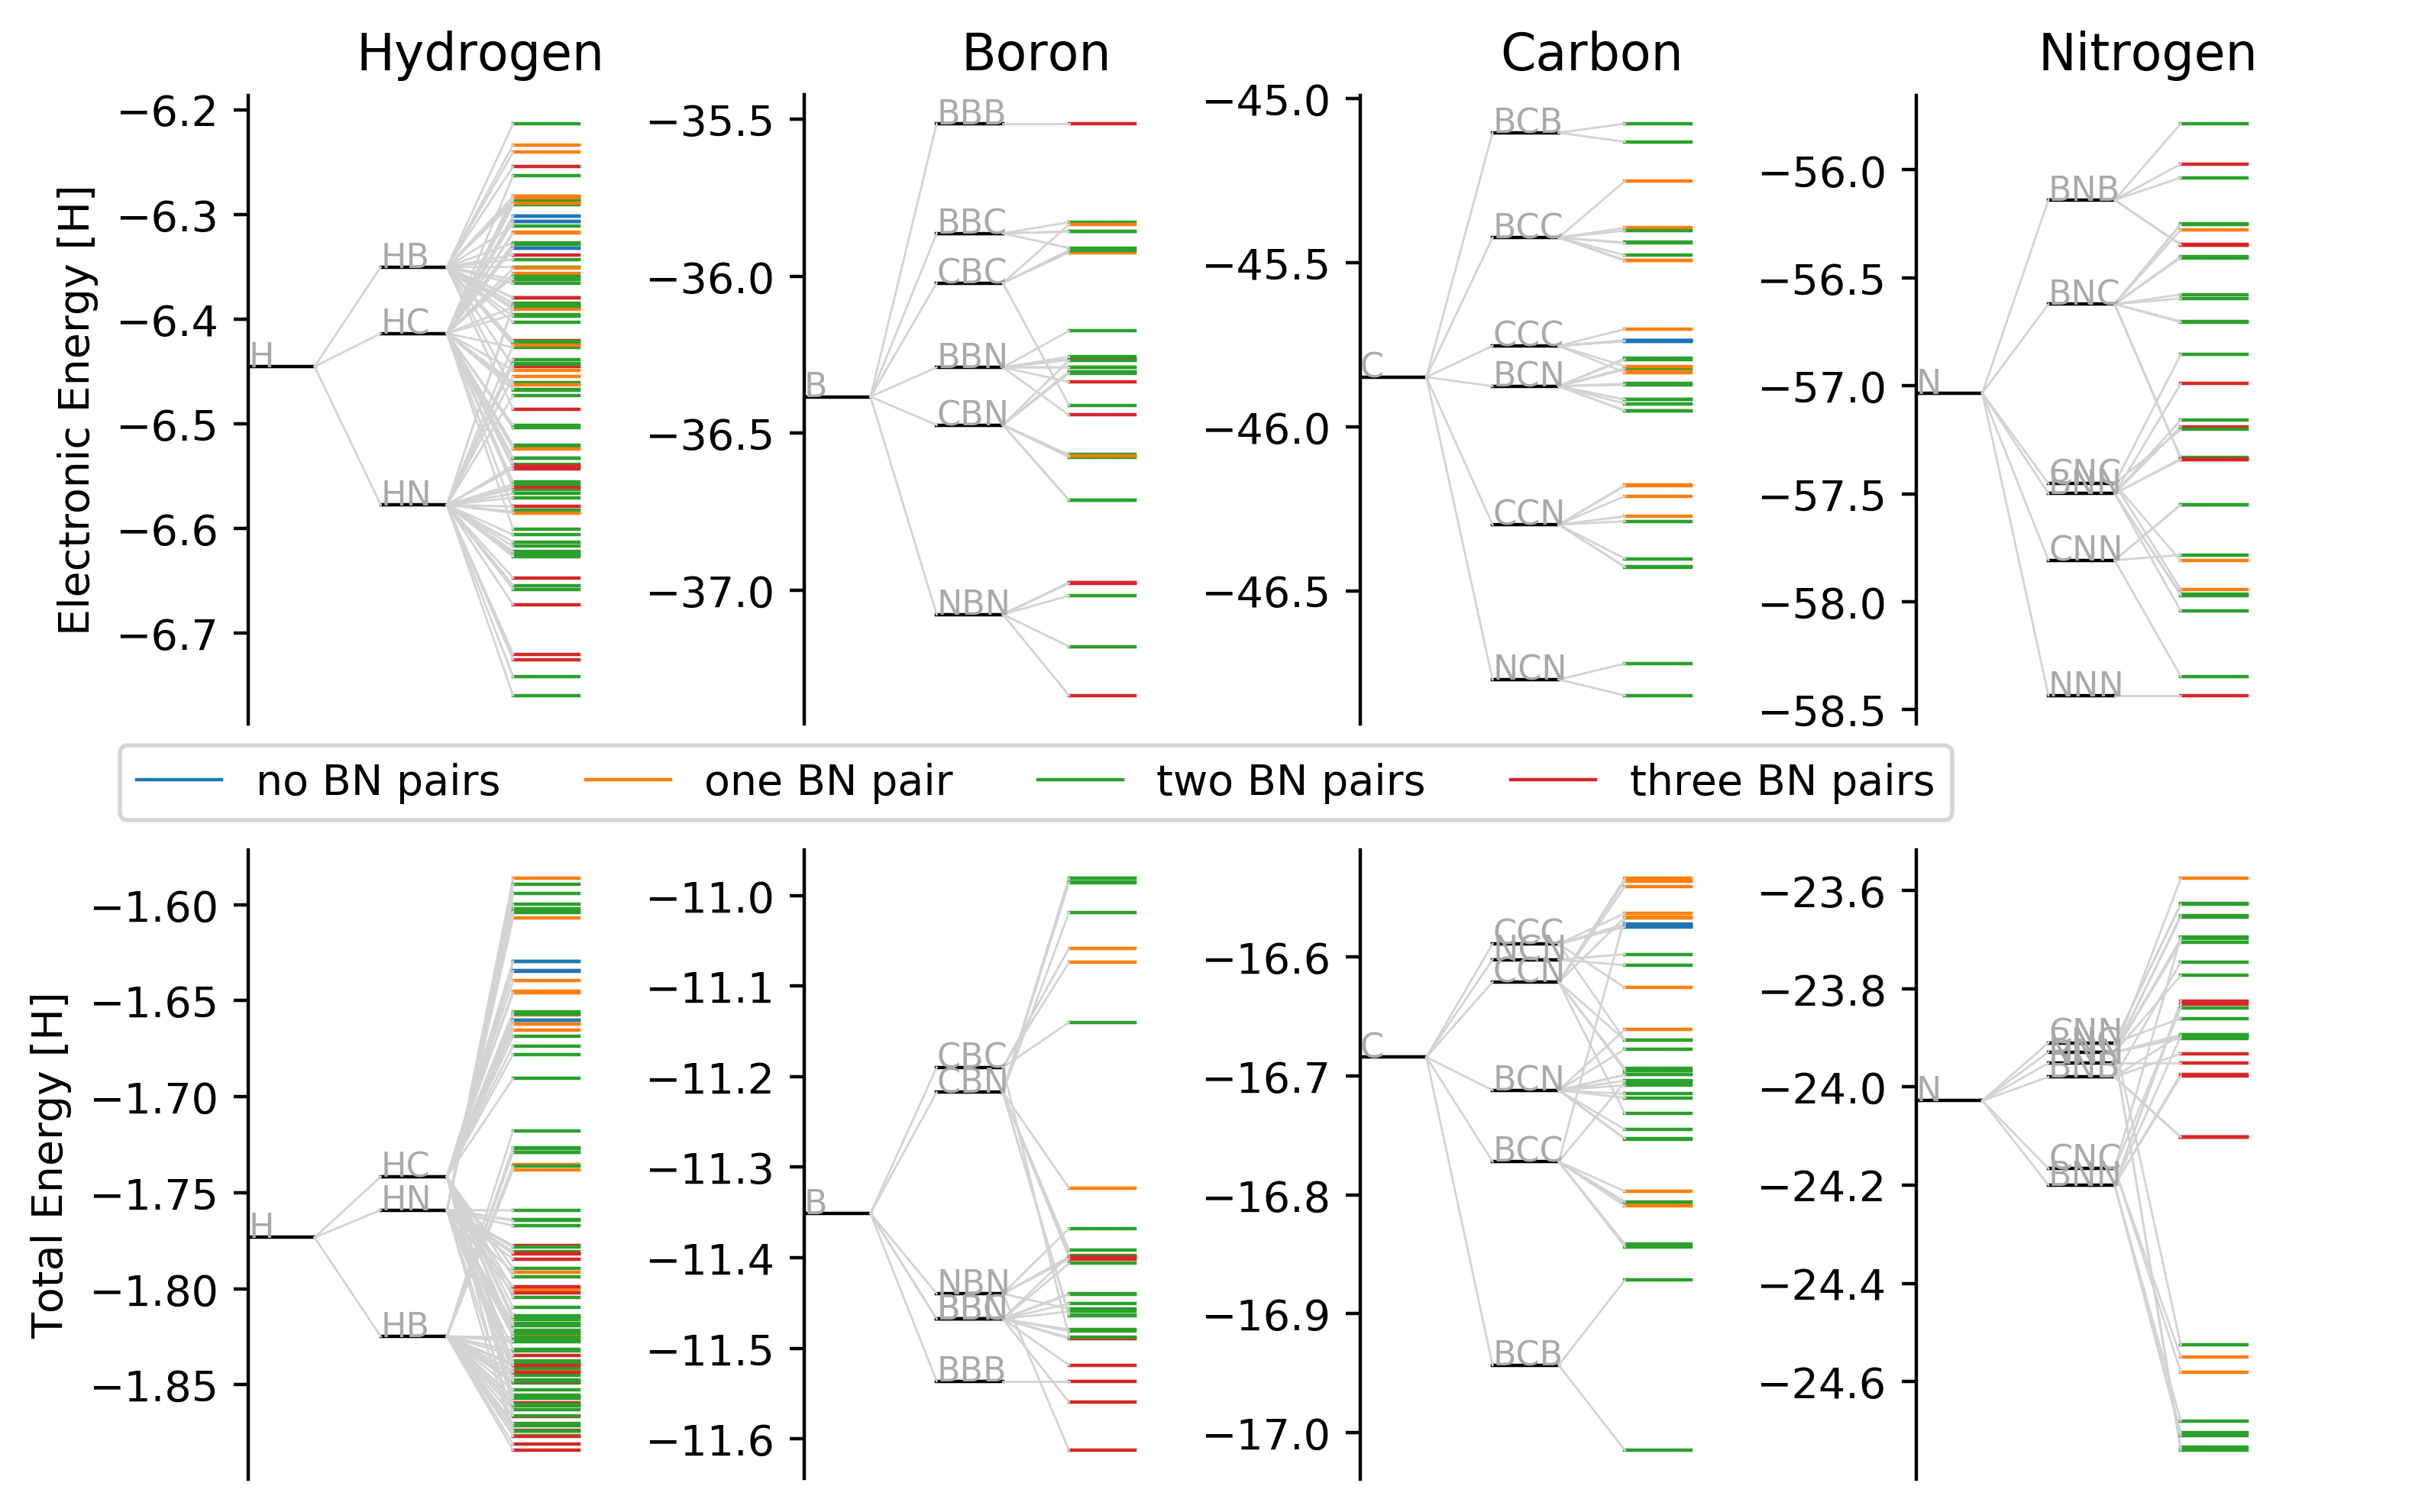

In [562]:
def statsplot():
    lookup = {'H': 1, 'B': 5, 'C': 6, 'N': 7}
    rlookup = {1:'H', 5:'B', 6:'C', 7:'N'}
    
    def pretty_label(label):
        if len(label) < 3: return label
        if len(label) == 3:
            return {'1-5': 'HB', '1-6': 'HC', '1-7':'HN'}[label]
        this = rlookup[int(label[0])]
        nn1 = rlookup[int(label[-2])]
        nn2 = rlookup[int(label[-1])]
        return '%s%s%s' % (nn1, this, nn2)
        
    def draw_bar(ax, x, y, width, label, color):
        ax.text(x, y, pretty_label(label), fontsize=8, color='darkgrey')
        return ax.plot((x, x+width), (y, y), color=color, lw=0.8)
    
    def connect_bars(ax, x, y1, y2, width):
        ax.plot((x, x+width), (y1, y2), color='lightgrey', lw=0.5)
        
    f, axs = plt.subplots(2, 4, dpi=400, figsize=(9, 6), sharex=True)
    
    axs1, axs2 = axs
    axeH, axeB, axeC, axeN = axs1
    axtH, axtB, axtC, axtN = axs2
    
    axeH.set_title('Hydrogen')
    axeB.set_title('Boron')
    axeC.set_title('Carbon')
    axeN.set_title('Nitrogen')
    axeH.set_ylabel('Electronic Energy [H]')
    axtH.set_ylabel('Total Energy [H]')
    
    legend_handles = {}
    for kind in 'HBCN':
        axe = locals()['axe' + kind]
        axt = locals()['axt' + kind]
        
        # layout
        for ax in (axe, axt):
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            ax.set_xlim(-1, 6)
        
        subset = stats[stats.statkey.str.startswith(str(lookup[kind]))]
        draw_bar(axe, -1, subset.electronic.mean(), 1, kind, 'black')
        draw_bar(axt, -1, subset.total.mean(), 1, kind, 'black')
            
        for name, group in subset.groupby('statkey'):
            draw_bar(axe, 1, group.electronic.mean(), 1, name, 'black')
            connect_bars(axe, 0, subset.electronic.mean(), group.electronic.mean(), 1)
            draw_bar(axt, 1, group.total.mean(), 1, name, 'black')
            connect_bars(axt, 0, subset.total.mean(), group.total.mean(), 1)
            for ridx, row in group.iterrows():
                draw_bar(axe, 3, row.electronic, 1, '', 'C' + str(row['bnpairs']))
                connect_bars(axe, 2, group.electronic.mean(), row.electronic, 1)
                legend_handles[row['bnpairs']] = draw_bar(axt, 3, row.total, 1, '', 'C' + str(row['bnpairs']))
                connect_bars(axt, 2, group.total.mean(), row.total, 1)
    
    # legend
    labels = ['no BN pairs', 'one BN pair', 'two BN pairs', 'three BN pairs']
    handles = [legend_handles[_][0] for _ in (0, 1, 2, 3)]
    axtB.legend(handles, labels, ncol=4, loc='upper center', bbox_to_anchor=(0, 0, 1, 1.2))
    
    plt.savefig('statsplot.pdf')
statsplot()

[-140.38560228 -134.46373709 -130.18434959 -125.7207918  -123.5901931
 -121.18731019]
[-107.97350026 -108.53406576 -108.57627681 -108.43433511 -108.33744099
 -108.2224711 ]
[-143.46043896 -137.69302598 -133.52885501 -129.19129342 -127.1160218
 -124.77129164]
[-111.70980841 -112.29253162 -112.36176331 -112.25762155 -112.17455034
 -112.0710411 ]
[-152.66492097 -147.356218   -143.52764028 -139.55577416 -137.65133923
 -135.49238007]
[-122.89870483 -123.54325454 -123.68349182 -123.68045678 -123.64370974
 -123.58589519]


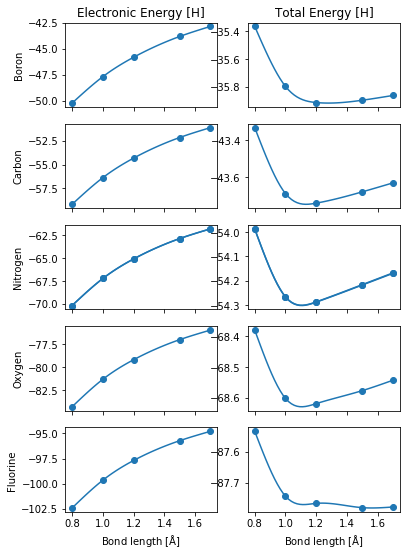

In [561]:
def dimer_plot(box):
    f, axs = plt.subplots(5, 2, figsize=(6, 9), sharex=True)
    pane = {'N2': (2,2), 'CO': (3, 1), 'BF': (4, 0)}
    lookup = {7:'N', 8:'O', 6:'C', 9:'F', 5:'B'}
    for tidx, target in enumerate('N2 CO BF'.split()):
        q = pd.merge(r[r.target.str.startswith(target)], energy_data[energy_data.target.str.startswith(target)])
        q = q[q.box == box].sort_values('target')
        ds = np.array([float(_.split('-')[-1]) for _ in q.target.values])
        zs = q.zs.values[0]
        hasE = -np.array(q.energies.tolist()).sum(axis=1) + np.array(q.enn.tolist()).sum(axis=1)
        shift = (q.energy.values - hasE) / sum(q.zs.iloc[0])
        ann_total = (-np.array(q.energies.tolist()) + np.array(q.enn.tolist()) + np.outer(shift, np.array(q.zs.iloc[0])))
        ann_elec = (-np.array(q.energies.tolist()) + np.outer(shift, np.array(q.zs.iloc[0])))
        for column in (0, 1):
            if column == 1:
                ann = ann_total
            else:
                ann = ann_elec
            if target != 'N2d':
                mask = np.where((ds < 2.0) & (ds != 1.22))[0]
            else:
                mask = np.where((ds < 2.0))[0]
            print (ann.sum(axis=1))
            for site in (0,1):
                xs = ds[mask]
                ys = ann[:, site][mask]
                xss = np.linspace(min(xs), max(xs), 50)
                spl = CubicSpline(xs, ys, bc_type='natural')
                ax = axs[pane[target][site], column]
                try:
                    root = [_ for _ in spl.derivative().roots() if 0.8 < _ and _ < 1.4][0]
                    #ax.axvline(root)
                    #print (lookup[zs[site]], root)
                except:
                    pass
                yss = spl(xss)
                ax.plot(xs, ys, 'o', label='%s' % lookup[zs[site]], color='C0')
                ax.plot(xss, yss, color='C0')
    
    axs[0, 0].set_ylabel('Boron')
    axs[1, 0].set_ylabel('Carbon')
    axs[2, 0].set_ylabel('Nitrogen')
    axs[3, 0].set_ylabel('Oxygen')
    axs[4, 0].set_ylabel('Fluorine')
    axs[-1, 0].set_xlabel('Bond length [$\mathrm{\AA}$]')
    axs[-1, 1].set_xlabel('Bond length [$\mathrm{\AA}$]')
    axs[0, 0].set_title('Electronic Energy [H]')
    axs[0, 1].set_title('Total Energy [H]')
    
    plt.savefig('dimer.pdf')
dimer_plot(15)

In [572]:
q = stats.groupby('statkey target'.split()).describe()['electronic']
qq = q['max'] - q['min']
qq[qq > 0.19]

statkey  target     
7-157    5-7-5-7-7-5    0.198607
dtype: float64

In [573]:
stats.query('target == "5-7-5-7-7-5"')

,bnpairs,electronic,statkey,target,total
168,3,-6.578783,1-7,5-7-5-7-7-5,-1.839858
169,3,-6.485820,1-5,5-7-5-7-7-5,-1.881007
170,3,-6.725001,1-7,5-7-5-7-7-5,-1.876847
171,3,-6.672571,1-7,5-7-5-7-7-5,-1.843517
172,3,-6.388303,1-5,5-7-5-7-7-5,-1.873613
173,3,-6.379683,1-5,5-7-5-7-7-5,-1.884106
174,3,-36.336161,5-157,5-7-5-7-7-5,-11.559458
175,3,-37.334945,5-177,5-7-5-7-7-5,-11.612616
176,3,-36.441685,5-157,5-7-5-7-7-5,-11.518706
177,3,-55.972200,7-155,5-7-5-7-7-5,-23.932472
